### Curves Package Introduction
The curve Python package offers a set of tools for the construction forward, futures or swap curves for commodities. This notebooks gives a introduction to most of the functionality, including practical examples. For the sake of brevity, in the following descriptions the curve will be referred to as a *forward* or *swap* curve even if the same functionality could be applied to either of these forward curve type, or futures curves.

#### Bootstrapper
The basic functionality of the method bootstrap_contracts is to take a set of forward prices for contracts, which have overlapping delivery periods, and return a curve with overlapping periods removed, but with prices consistent with the original inputs.
The example below shows a basic example shows input contract prices for January, February, and Q1 delivery period periods being bootstrapped into January, February and March forward prices.

In [28]:
from curves import bootstrap_contracts
from datetime import date

q1_price = 19.05
contracts = [
    (date(2019, 1, 1), 18.95), # Jan-19
    (date(2019, 1, 1), date(2019, 3, 1), q1_price) # Q1-19
]
piecewise_curve, bootstrapped_contracts = bootstrap_contracts(contracts, freq='M')
piecewise_curve


2019-01    18.950000
2019-02    19.102542
2019-03    19.102542
Freq: M, dtype: float64

We can now check that the three monthly prices average back to the Q1-19 price of 19.05.

In [29]:
back_calc_q1_price = (piecewise_curve['2019-01'] * 31.0 # 31 days in Jan-19
                    + piecewise_curve['2019-02'] * 28.0 # 28 days in Feb-19
                    + piecewise_curve['2019-03'] * 31.0 # 31 days in Mar-10
                     ) / (31.0 + 28.0 + 31.0)
print('Back calculated Q1-19 price: {:.5f}'.format(back_calc_q1_price))

Back calculated Q1-19 price: 19.05000


---
#### Appling Shaping Ratios and Spreads
The bootstrap_contracts function can apply further shaping to the derived curve in the form of predefined spreads or ratio. Taking the above example of the inputs being a single quarter and month, it might not be satisfactory that the Feb-19 and Mar-19 prices are equal. 

In [30]:
ratios = [
    (date(2019, 2, 1), date(2019, 3, 1), 1.1)    
]
curve_ratio_shaped, _ = bootstrap_contracts(contracts, shaping_ratios=ratios, freq='M')
print(curve_ratio_shaped)
print()
derived_feb_mar_ratio = curve_ratio_shaped['2019-02'] / curve_ratio_shaped['2019-03']
print('Output Feb/Mar ratio {:.5f}'.format(derived_feb_mar_ratio))

2019-01    18.950000
2019-02    20.060761
2019-03    18.237055
Freq: M, dtype: float64

Output Feb/Mar ratio 1.10000


***
The example below, again applies a shaping constraint to Feb-19 and Mar-19, but this time by enforcing a spread between these two prices.

In [31]:
spreads = [
    (date(2019, 2, 1), date(2019, 3, 1), 0.21)    
]
curve_spread_shaped, _ = bootstrap_contracts(contracts, shaping_spreads=spreads, freq='M')
print(curve_spread_shaped)
print()
derived_feb_mar_spread = curve_spread_shaped['2019-02'] - curve_spread_shaped['2019-03']
print('Output Feb-Mar spread {:.5f}'.format(derived_feb_mar_spread))

2019-01    18.950000
2019-02    19.212881
2019-03    19.002881
Freq: M, dtype: float64

Output Feb-Mar spread 0.21000


---
### Average Weighting
For some traded products the forward price does not simply consists of the unweighted mean of the prices for sub-period. Instead some sort of weighted average determines the arbitrage-free price. Examples of such products include:
* Swaps on indices which only publish on business days.
* Power forward contracts which don't deliver at a constant rate throughout the day. For example UK off-peak would deliver over 12 hours on a weekday, and 24 hours on a weekend.
The bootstrap_contracts function includes an optional average_weight parameter, which allows the specification of the weighting function as a callable. If the average_weight parameter isn't provided, the default behaviour is for weighting to equal the number of minutes in a delivery period.

The example below bootstraps the same January and Q1 prices, except with weighting equal to the number of weekdays.

In [32]:
import pandas as pd
def weekday_weight(period):
    start_day = period.asfreq('B', 's')
    end_day = period.asfreq('B', 'e')
    return len(pd.period_range(start=start_day, end=end_day, freq='B'))

curve_weekday, _ = bootstrap_contracts(contracts, freq='M', average_weight=weekday_weight)
curve_weekday

2019-01    18.950000
2019-02    19.106098
2019-03    19.106098
Freq: M, dtype: float64

As before, the validity of the resulting curve can be calculated by back-calculating the Q1-19 price and checking that it is equal to the input for this period.

In [33]:
q1_price_weekday = (curve_weekday['2019-01'] * 23.0 # 23 weekdays in Jan-19
                    + curve_weekday['2019-02'] * 20.0 # 20 days in Feb-19
                    + curve_weekday['2019-03'] * 21.0 # 21 days in Mar-10
                     ) / (23.0 + 20.0 + 21.0)
print('Q1-19 input price {:.5}'.format(q1_price))
print('Back calculated Q1-19 price: {:.5f}'.format(q1_price_weekday))

Q1-19 input price 19.05
Back calculated Q1-19 price: 19.05000


---
#### Contract Redundancy When Bootstrapping
In some circumstances redundant contract information might be passed into the bootstrap_contracts function. An example of this is if the Q1, Jan, Feb, and Mar prices are all present. Clearly the three monthly prices fully determine the Q1 price, hence the redundancy. The default behaviour of the bootstrapper is to throw an exception, as shown below.

In [34]:
redundant_contract = [
    (date(2019, 1, 1), 18.95), # Jan-19
    (date(2019, 2, 1), 18.23), # Feb-19
    (date(2019, 3, 1), 17.99), # Mar-19
    (date(2019, 1, 1), date(2019, 3, 1), 18.43) # Q1-19
]
try:
    bootstrap_contracts(redundant_contract, freq='M')
except Exception as e:
    print('The following exception was raised:')
    print(e)

The following exception was raised:
Redundant contracts and shapings are present
   at Cmdty.Curves.Bootstrapper`1.Calculate(List`1 contracts, Func`2 weighting, List`1 shapings, Boolean allowRedundancy)


The behaviour in the presence of redundancy can be modified by setting the allow_redundancy parameter to true as the example below shows. The resulting prices will be determined as a least-squares solution of the linear constraints which each input price represents. However, it is preferrable that redundant prices are not avoided if possible.

In [35]:
curve_redundant, _ = bootstrap_contracts(redundant_contract, freq='M', allow_redundancy=True)
curve_redundant

2019-01    18.975161
2019-02    18.257857
2019-03    18.015161
Freq: M, dtype: float64

---
### Curve Granularity
The granularity of the derived curves is controlled by the string passed in as the freq parameter. For returned values which are of type pandas.Series, this parameter is used when constructing these objects, with more details on the these freqency strings found in the pandas documentation [here](
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).
The package level dict variable FREQ_TO_PERIOD_TYPE contains a mapping between freq parameter values and the underlying managed types used to represent the resulting curve index type, and hence granularity. As such, the keys of FREQ_TO_PERIOD_TYPE can be used to determine the set of admissible values for the freq parameter.

In [36]:
from curves import FREQ_TO_PERIOD_TYPE
FREQ_TO_PERIOD_TYPE

{'15min': Cmdty.TimePeriodValueTypes.QuarterHour,
 '30min': Cmdty.TimePeriodValueTypes.HalfHour,
 'H': Cmdty.TimePeriodValueTypes.Hour,
 'D': Cmdty.TimePeriodValueTypes.Day,
 'M': Cmdty.TimePeriodValueTypes.Month,
 'Q': Cmdty.TimePeriodValueTypes.Quarter}

### Specifying Input Contract
In the examples so far, the delivery period of a contract is specified by either the Python built-in date type, either on it's own, or in the first and second element of the tuple. There are however several ways in which the delivery period part of the contract can be represented. The general form is one of the following:
* (\[period\], \[price\])
* (\[period start\], \[period end\], \[price\])
* ((\[period start\], \[period end\]), \[price\])

Hence the elements of the contract can be either a 2-tuple, or a 3-tuple, with the 2-tuple form potentially containing another tuple in the first element. In all of these forms he \[price\] part is simply a float instance. The \[period\], \[period start\], and \[period end\] parts can be instances of any of the following types:
* pandas.Period
* built-in date
* build-in datetime

#### contract_period Helper Module
The curves package contains a helper module contract_period which contains various methods to help with the creation of the delivery period part of the contract. Most, but not all, of the methods return instances of pandas.Period as the example below shows.

In [37]:
from curves import contract_period

print('Creating months:')
jan19 = contract_period.month(2019, 1)
print(repr(jan19))

feb19 = contract_period.feb(2019)
print(repr(feb19))

print()
print('Creating quarters:')
q119 = contract_period.quarter(2019, 1)
print(repr(q119))

q219 = contract_period.q_2(2019)
print(repr(q219))

print()
print('Creating seasons:')
sum19 = contract_period.summer(2019)
print(repr(sum19))

win19 = contract_period.winter(2019)
print(repr(win19))

print()
print('Creating calendar years:')
cal19 = contract_period.cal_year(2019)
print(repr(cal19))

cal20 = contract_period.cal_year(2020)
print(repr(cal20))

print()
print('Creating gas years:')
gy19 = contract_period.gas_year(2019)
print(repr(gy19))

gy20 = contract_period.gas_year(2020)
print(repr(gy20))


Creating months:
Period('2019-01', 'M')
Period('2019-02', 'M')

Creating quarters:
Period('2019Q1', 'Q-DEC')
Period('2019Q2', 'Q-DEC')

Creating seasons:
Period('2019Q2', '2Q-DEC')
Period('2019Q4', '2Q-DEC')

Creating calendar years:
Period('2019', 'A-DEC')
Period('2020', 'A-DEC')

Creating gas years:
(datetime.date(2019, 10, 1), datetime.date(2020, 9, 30))
(datetime.date(2020, 10, 1), datetime.date(2021, 9, 30))


---
### Spline Interpolation
In order to facility creating a curve with higher granularity than the input contracts, the curves package includes the max_smooth_interp function. This uses a maximum smoothness algorithm to interpolate input contracts with fourth-order spline, whilst maintaining the average price constraints inherent in the input contract prices.

The example below creates a daily granularity curve, from input contracts of various granularities. As would usually be the case in a practical scenario, the bootstrap_contracts method is first used to remove the overlaps from the contracts. The example below also shows how the input contracts can have gaps between them, which the spline will interpolate over, filling in the gaps in the final smooth curve. It also demonstrates the different ways of representing the contract delivery period in the contract tuples.

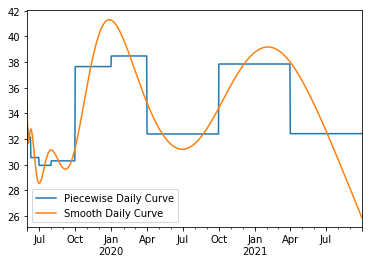

In [38]:
from curves import max_smooth_interp
from curves import contract_period as cp

contracts = [
    (date(2019, 5, 31), 34.875), 
    (date(2019, 6, 1), date(2019, 6, 2), 32.87),
    ((date(2019, 6, 3), date(2019, 6, 9)), 32.14),
    (pd.Period(year=2019, month=6, freq='M'), 31.08),
    (cp.month(2019, 7), 29.95),
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.winter(2019), 38.05),
    (cp.summer(2020), 32.39),
    (cp.winter(2020), 37.84),
    (cp.gas_year(2020), 35.12)
]

pc_for_spline, bc_for_spline = bootstrap_contracts(contracts, freq='D')
smooth_curve = max_smooth_interp(bc_for_spline, freq='D')

%matplotlib inline
pc_for_spline.plot(legend=True)
ax = smooth_curve.plot(legend=True)
ax.legend(["Piecewise Daily Curve", "Smooth Daily Curve"])

#### Interpolating Pandas Series
The contracts parameter to max_smooth_interp can also be an instance of the pandas Series type, with the example below showing an example of interpolating a monthly series to daily granularity.

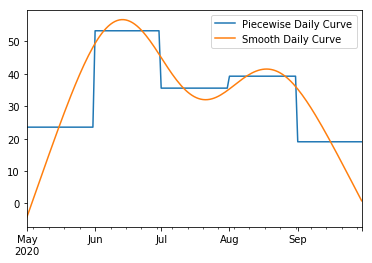

In [39]:
monthly_curve = pd.Series(data=[23.53, 53.245, 35.56, 39.242, 19.024], 
                          index=pd.period_range(start=pd.Period(year=2020, month=5, freq='M'), periods=5))
smooth_daily_curve = max_smooth_interp(monthly_curve, freq='D')
piecewise_daily_curve = monthly_curve.resample('D').fillna('pad')

%matplotlib inline
piecewise_daily_curve.plot(legend=True)
ax = smooth_daily_curve.plot(legend=True)
ax.legend(["Piecewise Daily Curve", "Smooth Daily Curve"])

#### Controlling The Spline Slope
In the above example it could theoretically not be desirable for the smooth curve to carry on sloping down at the back end. The optional parameter back_1st_deriv can be used to constrain the slope of the curve (1st derivative with respect to time) at the very end of the curve. See below for an example of setting back_1st_deriv to a positive numer in order to make the curve slope upwards at the end.
This is useful in practice as usually the input contract get less granular further back the curve which could easily result in the spline producing a smooth curve which has a shape which is inconsistent with how the commodity price should behave due to fundamentals. The use of the back_1st_deriv parameter allows some control, albeit on in a arbitrary manner.

There is another optional parameter front_1st_deriv which applies the same slope constraint, except at the very front of the curve. However, this parameter will be used much less in practice as the front of the curve will have the highest granularity input contracts, hence the curve shape will be more finely controlled by this market data.

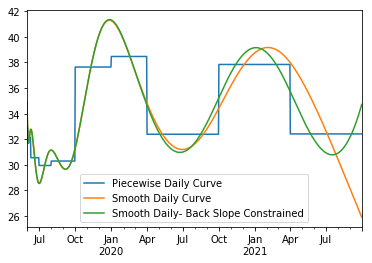

In [40]:
back_end_slope = 0.11
smooth_curve_back_slope = max_smooth_interp(bc_for_spline, freq='D', back_1st_deriv=back_end_slope)

pc_for_spline.plot(legend=True)
smooth_curve.plot(legend=True)
ax = smooth_curve_back_slope.plot(legend=True)
ax.legend(["Piecewise Daily Curve", "Smooth Daily Curve", "Smooth Daily- Back Slope Constrained"])

#### Shaping the Spline
Many commodities shows seasonality in the day of week, such as power and gas. In these cases the daily curve produced by the above spline is clearly not sufficient in that such seasonality isn't reflected reflected in the smooth curve. The spline function includes two optional parameters, mult_season_adjust and add_season_adjust which allow an arbitrary adjustment function to be applied to the spline whilst the constraint that the spline averages back to the input contract prices is still maintained.

The example below shows how mult_season_adjust is used to apply an adjustment based on the day of the week. However, the adjustment function can be any function on pandas.Period which returns a float. See the function docstring for more details.

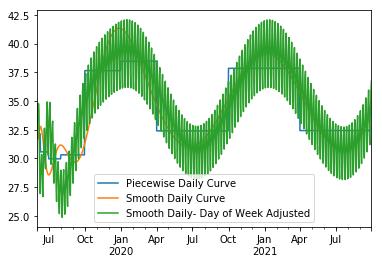

In [41]:
dow_mults = {
    0 : 0.99,
    1 : 1.01,
    2 : 1.05,
    3 : 1.07,
    4 : 1.02,
    5 : 0.95,
    6 : 0.92,
}

def mult_adjust(period):
    return dow_mults[period.dayofweek]

smooth_curve_mult_adjust = max_smooth_interp(bc_for_spline, freq='D', mult_season_adjust=mult_adjust, back_1st_deriv=back_end_slope)

pc_for_spline.plot(legend=True)
smooth_curve_back_slope.plot(legend=True)
ax = smooth_curve_mult_adjust.plot(legend=True)
ax.legend(["Piecewise Daily Curve", "Smooth Daily Curve", "Smooth Daily- Day of Week Adjusted"])

#### Adjustments Helper Module
To help with creating functions for the mult_season_adjust and add_season_adjust parameters, the curves package contains the helper module adjustments. This module provides functions which can be called to create functions for use as these spline adjustment function parameters.

The example below shows how adjustments.dayofweek function to create an additive adjusment function. See the docstring of adjustments.dayofweek for more details.

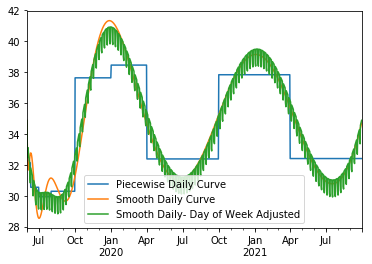

In [42]:
from curves import adjustments

add_adjust = adjustments.dayofweek(default=0.0, saturday=-0.9, sunday=-1.1)

smooth_curve_add_adjust = max_smooth_interp(bc_for_spline, freq='D', add_season_adjust=add_adjust, back_1st_deriv=back_end_slope)

pc_for_spline.plot(legend=True)
smooth_curve_back_slope.plot(legend=True)
ax = smooth_curve_add_adjust.plot(legend=True)
ax.legend(["Piecewise Daily Curve", "Smooth Daily Curve", "Smooth Daily- Day of Week Adjusted"])

#### Weighting Helper Module
Both the bootstrapper and spline methods have a parameter called average_weight which specifies the weighting scheme applied when calculating the price of a traded contract from prices at a higher granularity. The curves package includes the module weighting which provides functions to help with creating these weighting functions.

The example below shows an example of using weighting.num_business_days to create a weighting function which counts the number of business days in a contract delivery period. In practice, such a weighting function would be used when constructing swap curves on products which only publish an index on business days.

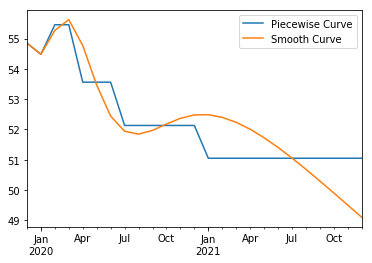

In [43]:
from curves import weighting

holidays = [
    date(2019, 12, 25),
    date(2019, 12, 26),
    date(2020, 1, 1),
    # Put more holidays here...
]

bus_day_weighting = weighting.num_business_days(holidays=holidays)

bus_day_contracts = [
    (cp.dec(2019), 54.85),
    (cp.jan(2020), 54.48),
    (cp.q_1(2020), 55.12),
    (cp.q_2(2020), 53.56),
    (cp.cal_year(2020), 53.22),
    (cp.cal_year(2021), 51.05),
]

pc_bus_day, bc_bus_day = bootstrap_contracts(bus_day_contracts, freq='M', average_weight=bus_day_weighting)
bus_day_smooth_curve = max_smooth_interp(bc_bus_day, freq='M', average_weight=bus_day_weighting)

pc_bus_day.plot(legend=True)
ax = bus_day_smooth_curve.plot(legend=True)
ax.legend(['Piecewise Curve', 'Smooth Curve'])